In [3]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from src.load_data import load_sheet, clean_sheet_with_label
from src.isolation_forest import create_pipeline, score_and_map_anomalies, tuning_contamination_rate, plot_anomaly_detection, plot_anomaly_detection_each_run, convert_labels_to_binary

%load_ext autoreload
%matplotlib
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: module://matplotlib_inline.backend_inline


In [4]:
internal_df, sheet1 = load_sheet("Electroplate Experiments Data JUN_JUL", "vary_internal_table")
internal_df = clean_sheet_with_label(internal_df)
# two_side_plate, sheet2 = load_sheet("Electroplate Experiments Data JUN_JUL", "2 side Experimental Result")
# two_side_plate = clean_sheet_with_label(two_side_plate)
august_df, sheet3 = load_sheet("Electroplating Experiments Data August", "Sheet1")
august_df = clean_sheet_with_label(august_df)
september_df, sheet4 = load_sheet("Electroplating Experiments Data September", "Sheet1")
september_df = clean_sheet_with_label(september_df)

In [5]:
df = pd.concat([internal_df, august_df, september_df]).reset_index(drop=True)
df['index'] = df.groupby('run_id').cumcount() + 1
time_index_series = df.pop('index')
df.insert(0, 'index', time_index_series)

In [6]:
df

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
0,1,JUL_3_1,2025-07-03 11:21:05,1,1,67,Brass,Nickel,0.80,270.0,...,4.02,,50.36,,3.649,,2.342,0.001,0.6289,Fresh
1,2,JUL_3_1,2025-07-03 11:21:06,1,2,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.568,,2.342,0.001,0.6289,Fresh
2,3,JUL_3_1,2025-07-03 11:21:07,1,3,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.509,,2.342,0.002,0.6289,Fresh
3,4,JUL_3_1,2025-07-03 11:21:08,1,4,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.509,,2.342,0.003,0.6289,Fresh
4,5,JUL_3_1,2025-07-03 11:21:09,1,5,67,Brass,Nickel,0.80,270.0,...,4.02,,50.35,,3.475,,2.342,0.003,0.6289,Fresh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74144,596,OCT_24_4,2025-10-24 15:17:30,2,5994,67,Brass,Nickel,0.35,270.0,...,3.95,None,50.40,None,4.443,None,2.343,3.901,0.6310,Bath_10
74145,597,OCT_24_4,2025-10-24 15:17:32,2,5996,67,Brass,Nickel,0.35,270.0,...,3.95,None,50.37,None,4.480,None,2.343,3.903,0.6310,Bath_10
74146,598,OCT_24_4,2025-10-24 15:17:34,2,5998,67,Brass,Nickel,0.35,270.0,...,3.95,None,50.36,None,4.472,None,2.343,3.904,0.6310,Bath_10
74147,599,OCT_24_4,2025-10-24 15:17:36,2,6000,67,Brass,Nickel,0.35,270.0,...,3.95,None,50.37,None,4.436,None,2.343,3.905,0.6310,Bath_10


In [7]:
NORMAL_RUNS = ['JUL_22_4', 'JUL_22_5', 'JUL_22_7']
NORMAL_CONDUCTIVITY_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_4', 'JUL_22_5', 'JUL_22_7']

In [19]:
df_train = df[df['run_id'].isin(NORMAL_CONDUCTIVITY_RUNS)].reset_index(drop=True)
df_train.index = df_train['run_id'].index + 1
df_train.head(5)

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
1,1,JUL_22_1,2025-07-22 13:17:40,2,2,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.639,N,2.342,0.002,0.6329,Bath_3
2,2,JUL_22_1,2025-07-22 13:17:42,2,4,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.70,N,3.705,N,2.342,0.004,0.6329,Bath_3
3,3,JUL_22_1,2025-07-22 13:17:44,2,6,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.71,N,3.702,N,2.342,0.006,0.6329,Bath_3
4,4,JUL_22_1,2025-07-22 13:17:46,2,8,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.68,N,3.673,N,2.342,0.008,0.6329,Bath_3
5,5,JUL_22_1,2025-07-22 13:17:49,2,10,67,Brass,Nickel,0.35,270.0,...,4.02,N,49.69,N,3.668,N,2.342,0.010,0.6329,Bath_3


In [20]:
ANOMALY_LABEL_COL = ['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'] # The new column containing 0 (Normal) or 1 (Anomaly)
# BINARY_LABEL_COL = ['True_Anomaly_C', 'True_Anomaly_P', 'True_Anomaly_T', 'True_Anomaly_V']
for i in range(4):
	df_train[ANOMALY_LABEL_COL[i]] = convert_labels_to_binary(df_train[ANOMALY_LABEL_COL[i]])


# lb = LabelEncoder()
# for col in ANOMALY_LABEL_COL:
# 	df_train[col] = lb.fit_transform(df_train[ANOMALY_LABEL_COL])

In [21]:
df_train.head(5)

,index,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,...,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id
1,1,JUL_22_1,2025-07-22 13:17:40,2,2,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.70,0,3.639,0,2.342,0.002,0.6329,Bath_3
2,2,JUL_22_1,2025-07-22 13:17:42,2,4,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.70,0,3.705,0,2.342,0.004,0.6329,Bath_3
3,3,JUL_22_1,2025-07-22 13:17:44,2,6,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.71,0,3.702,0,2.342,0.006,0.6329,Bath_3
4,4,JUL_22_1,2025-07-22 13:17:46,2,8,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.68,0,3.673,0,2.342,0.008,0.6329,Bath_3
5,5,JUL_22_1,2025-07-22 13:17:49,2,10,67,Brass,Nickel,0.35,270.0,...,4.02,0,49.69,0,3.668,0,2.342,0.010,0.6329,Bath_3


In [22]:
ANOMALY_LABEL_COL = ['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V']
for anomaly in ANOMALY_LABEL_COL:
    print(f"{anomaly} : {df_train[anomaly].unique()}")


Anomaly C : [0]
Anomaly P : [0]
Anomaly T : [0]
Anomaly V : [0 1]


# Ground Truth from laboratory

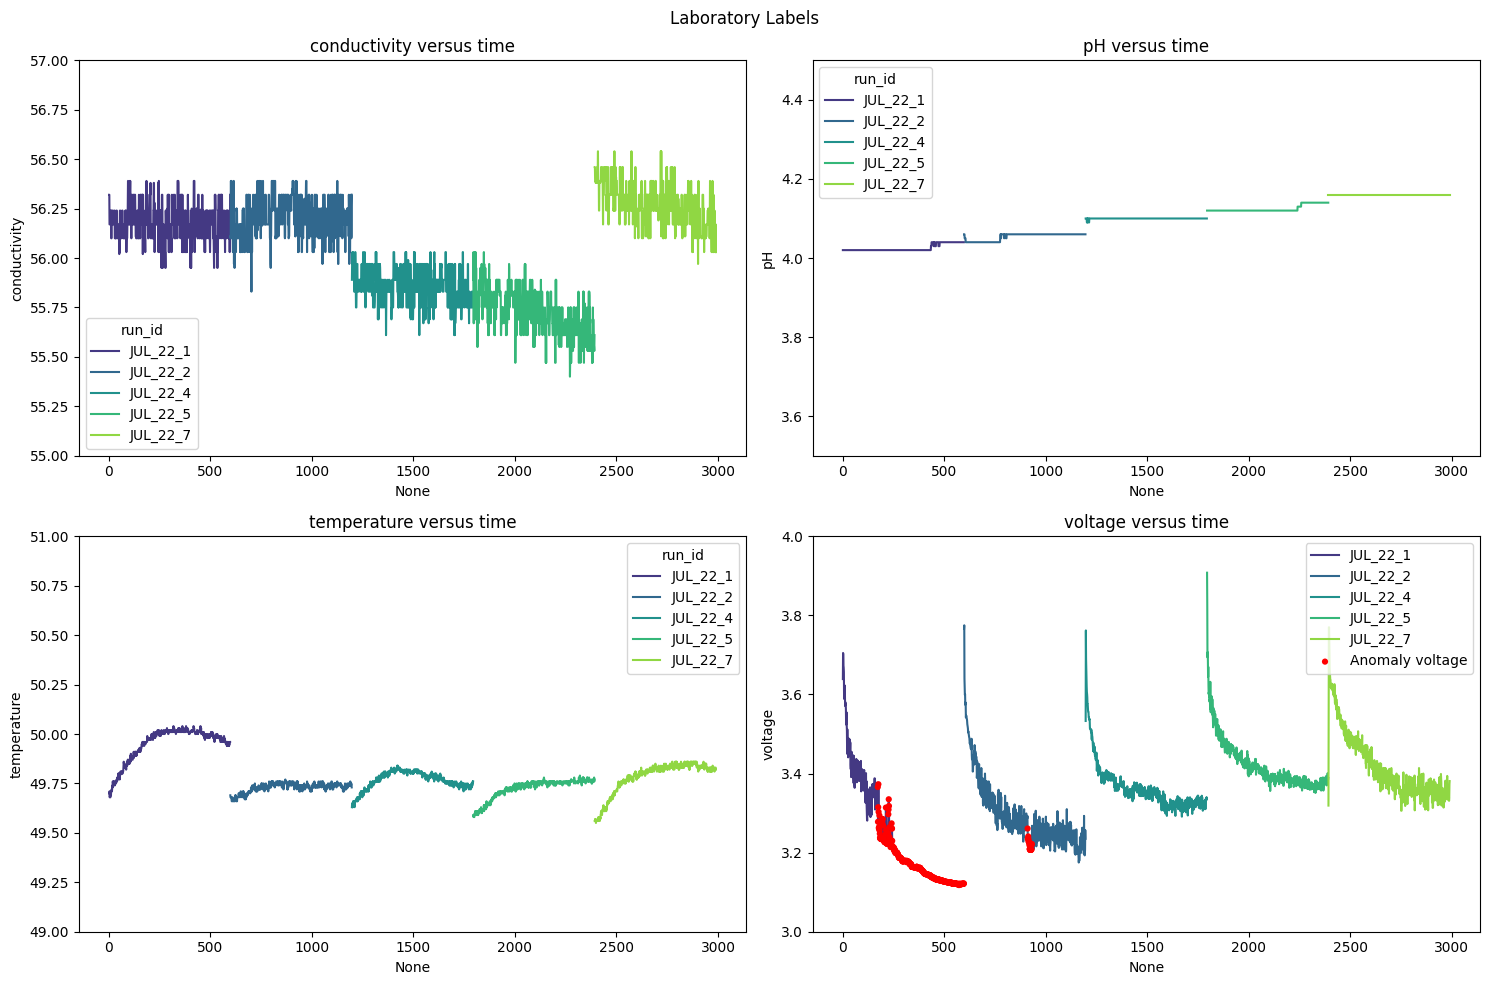

In [ ]:
PARAM = ['conductivity', 'pH', 'temperature', 'voltage']
ANOMALY_LABEL_COL = ['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V']
YLIM = {
    'conductivity': [55, 57], 
    'pH': [3.5, 4.5], 
    'temperature':[49, 51], 
    'voltage':[3, 4]
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
idx = 0
for i in range(2):
    for j in range(2):

        sns.lineplot(
            data=df_train,
            x=df_train.index,
            y=PARAM[idx],
            hue='run_id',
            palette='viridis',
            
            # s=50,
            ax=axes[i, j]
        )
        df_anomalies = df_train[df_train[ANOMALY_LABEL_COL[idx]] == 1]
        if len(df_anomalies) != 0:
            sns.scatterplot(
                data=df_anomalies,
                x=df_anomalies.index,
                y=PARAM[idx],
                ax=axes[i, j],
                # marker='X',
                zorder=10,
                s=20,
                color='red',
                edgecolor='none',
                label=f'Anomaly {PARAM[idx]}'
            )

        axes[i, j].set_title(f"{PARAM[idx]} versus time")
        axes[i, j].set_ylim(YLIM[PARAM[idx]][0], YLIM[PARAM[idx]][1])
        idx += 1
plt.suptitle("Laboratory Labels")
plt.tight_layout()
plt.show()
